# Project: Analysis of TMDb Movie Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
    <ul>
    <li><a href="#q1">Question 1</a></li>
    <li><a href="#q2">Question 2</a></li>
    <li><a href="#q3">Question 3</a></li>
    </ul>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction



The Movie DataBase is a website for exploring and reviewing movies using a collaborative database.<sup>1</sup> The data analyzed in this project is an excerpt of this database and includes information like involved parties, finances and popularity. 

I want to have a look on
1. how much money is spent on which genre, and if this differs over time
2. is there a correlation between money spent on films and their revenue, popularity or TMDb rating
3. Does the movie runtime correlate with money spent on it (are longer movies also more expensive?) Is there a significant change for 1. with budget normed to runtime?




<sup>1</sup> [Source](https://de.wikipedia.org/wiki/The_Movie_Database)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as dts
from datetime import datetime as dt
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### General Properties



First, I load the data and check out the style of the data and its length.

In [2]:
movie_data = pd.read_csv('tmdb-movies.csv')
print(movie_data.shape)
movie_data.head()

(10866, 21)


,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


There are 10866 movies in the data.

With the DataFrame head, I can describe the functions and style of the columns:
* The first two columns are for identifying the movies. I don't need both for this analysis, so I will drop one. 
* Popularity seems to be a percentage value, but this is to be checked.
* Budget and revenue are values in Dollar.
* original_title shows the movie title in a string. It is not important for the analysis, but I prefer to have an identifier I can relate to for each row, so I will keep it.
* The cast is listed in the next column, different actors divided by |. This would need some cleaning, but for this analysis I can drop it.
* homepage, director, tagline, keywords<sup>1</sup>  and overview are other non-useful columns to be dropped.
* runtime shows the movie length in minutes.
* Each movie has different genre tags in genres and companies in production_companies, also separated by | and need cleaning. production_companies can be dropped as it isn't needed.
* release_date shows the exact movie release date. I don't need this level of accuracy, I will drop it and use release_year.
* vote_count shows the number of votes given on the website for each movie, vote_average the outcome of this vote
* release_year (already shown in release_date, double info?
* The last 2 columns show budget and revenue normed to the dollar rate in 2010 to eliminate inflation distortion


<sup>1</sup> Here shown as ... due to lack of space, visible after dropping some columns



### Data Cleaning


First, I drop irrelevant columns and check the date types of all others.


In [3]:
movie_data.drop(['imdb_id', 'cast', 'homepage', 'release_date', \
                 'director', 'tagline', 'keywords', 'overview', 'production_companies'], axis=1, inplace=True)

movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 12 columns):
id                10866 non-null int64
popularity        10866 non-null float64
budget            10866 non-null int64
revenue           10866 non-null int64
original_title    10866 non-null object
runtime           10866 non-null int64
genres            10843 non-null object
vote_count        10866 non-null int64
vote_average      10866 non-null float64
release_year      10866 non-null int64
budget_adj        10866 non-null float64
revenue_adj       10866 non-null float64
dtypes: float64(4), int64(6), object(2)
memory usage: 1018.8+ KB


All columns have a fitting data type. 

Some movies miss a genre description as genres has less values than the other columns. I need to check for which this is the case and what happened there.

In [4]:
movie_data[movie_data.isnull().any(axis=1)] # source: https://stackoverflow.com/questions/43424199/display-rows-with-one-or-more-nan-values-in-pandas-dataframe

,id,popularity,budget,revenue,original_title,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj
424,363869,0.244648,0,0,Belli di papÃ,100,NaN,21,6.1,2015,0.00000,0.0
620,361043,0.129696,0,0,All Hallows' Eve 2,90,NaN,13,5.0,2015,0.00000,0.0
997,287663,0.330431,0,0,Star Wars Rebels: Spark of Rebellion,44,NaN,13,6.8,2014,0.00000,0.0
1712,21634,0.302095,0,0,Prayers for Bobby,88,NaN,57,7.4,2009,0.00000,0.0
1897,40534,0.020701,0,0,Jonas Brothers: The Concert Experience,76,NaN,11,7.0,2009,0.00000,0.0
2370,127717,0.081892,0,0,Freshman Father,0,NaN,12,5.8,2010,0.00000,0.0
2376,315620,0.068411,0,0,Doctor Who: A Christmas Carol,62,NaN,11,7.7,2010,0.00000,0.0
2853,57892,0.130018,0,0,Vizontele,110,NaN,12,7.2,2001,0.00000,0.0
3279,54330,0.145331,0,0,ì•„ê¸°ì™€ ë‚˜,96,NaN,11,6.1,2008,0.00000,0.0
4547,123024,0.520520,0,0,London 2012 Olympic Opening Ceremony: Isles of...,220,NaN,12,8.3,2012,0.00000,0.0


This shows that there is a data corruption in the database: some rows have missing values shown as 0. For the analysis, I need to get rid of these. I will delete the rows with missing budget completely because I need this value for all my questions and a movie without budget is not possible.

In [5]:
movie_data = movie_data.loc[movie_data.loc[:, 'budget'] != 0]

movie_data.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,5170.000000,5170.000000,5.170000e+03,5.170000e+03,5170.000000,5170.000000,5170.000000,5170.000000,5.170000e+03,5.170000e+03
mean,45513.083366,0.992323,3.073943e+07,8.027566e+07,107.093230,408.593424,6.032108,2001.252805,3.688774e+07,1.021757e+08
std,72723.324150,1.329145,3.890065e+07,1.594749e+08,22.808798,788.249398,0.884156,11.775932,4.195701e+07,1.959055e+08
min,5.000000,0.001117,1.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,9.210911e-01,0.000000e+00
25%,8840.500000,0.348024,6.000000e+06,0.000000e+00,93.000000,35.250000,5.500000,1996.000000,8.102293e+06,0.000000e+00
50%,13010.000000,0.623921,1.700000e+07,2.100078e+07,103.000000,122.000000,6.100000,2005.000000,2.272271e+07,2.853699e+07
75%,44935.250000,1.152401,4.000000e+07,8.942473e+07,117.000000,402.000000,6.600000,2010.000000,5.007483e+07,1.133573e+08
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,540.000000,9767.000000,8.400000,2015.000000,4.250000e+08,2.827124e+09


There still seem to be some wrong data as there are missing values for runtime. I will have a look on these.

In [6]:
movie_data.nsmallest(10, 'runtime') # from https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nsmallest.html

,id,popularity,budget,revenue,original_title,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj
1289,286372,0.037459,3250000,0,Treehouse,0,Thriller|Horror|Mystery,16,3.4,2014,2.993546e+06,0.0
4063,28004,0.371510,6000000,0,Madea's Family Reunion,0,Comedy,49,5.9,2002,7.273568e+06,0.0
6383,26985,0.371630,2000000,0,The 12 Dogs of Christmas,0,Drama|Family,11,4.7,2005,2.233127e+06,0.0
1289,286372,0.037459,3250000,0,Treehouse,0,Thriller|Horror|Mystery,16,3.4,2014,2.993546e+06,0.0
4063,28004,0.371510,6000000,0,Madea's Family Reunion,0,Comedy,49,5.9,2002,7.273568e+06,0.0
6383,26985,0.371630,2000000,0,The 12 Dogs of Christmas,0,Drama|Family,11,4.7,2005,2.233127e+06,0.0
1289,286372,0.037459,3250000,0,Treehouse,0,Thriller|Horror|Mystery,16,3.4,2014,2.993546e+06,0.0
4063,28004,0.371510,6000000,0,Madea's Family Reunion,0,Comedy,49,5.9,2002,7.273568e+06,0.0
6383,26985,0.371630,2000000,0,The 12 Dogs of Christmas,0,Drama|Family,11,4.7,2005,2.233127e+06,0.0
3656,76122,0.378240,500000,0,Marvel One-Shot: The Consultant,4,Adventure|Fantasy|Science Fiction|Action,66,6.7,2011,4.846990e+05,0.0


There are definitely values missing and shown as 0, but I will not delete this rows as I can them use for analysis not looking on runtime. I will look into this later when I need these values. Same goes for revenue.


Finally, I need to get rid of duplicates.

In [7]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html

movie_data.drop_duplicates(inplace=True)

Now I can start exploring the data, although there may be the need of more data cleaning later.




<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

<a id='q1'></a>

### Research Question 1: How much money is spent on which genre, and does this differ over time?

To give an answer to this question, I need to group the data by genre. As there are more than one genre per movie, I first need to create for each movie a dataframe row per each genre definition.

In [8]:
# Sources:
# https://www.mikulskibartosz.name/how-to-split-a-list-inside-a-dataframe-cell-into-rows-in-pandas/
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html

def split_per_genre(data, keep_list):
    # generate new splitted columns and merge them into the data
    split_data = data['genres'].str.split(expand=True, pat='|') \
        .merge(data, left_index = True, right_index = True)
    
    # drop old column
    split_data.drop(['genres'], axis=1, inplace=True)

    # build new genre column with one line for each genre per film
    split_data = pd.melt(split_data, id_vars= keep_list, value_name='genre')

    # 'variable' is useless, so drop it. Also drop rows with empty genre
    split_data.drop(['variable'], axis=1, inplace=True)
    split_data.dropna(inplace=True)
    return split_data

keep_list = ['id', 'popularity', 'budget', 'revenue', 'original_title', 'runtime', \
                                  'vote_count', 'vote_average', 'release_year', 'budget_adj', 'revenue_adj']
movie_data_split_genre = split_per_genre(movie_data, keep_list)
movie_data_split_genre.head()

,id,popularity,budget,revenue,original_title,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,genre
0,135397,32.985763,150000000,1513528810,Jurassic World,124,5562,6.5,2015,1.379999e+08,1.392446e+09,Action
1,76341,28.419936,150000000,378436354,Mad Max: Fury Road,120,6185,7.1,2015,1.379999e+08,3.481613e+08,Action
2,262500,13.112507,110000000,295238201,Insurgent,119,2480,6.3,2015,1.012000e+08,2.716190e+08,Adventure
3,140607,11.173104,200000000,2068178225,Star Wars: The Force Awakens,136,5292,7.5,2015,1.839999e+08,1.902723e+09,Action
4,168259,9.335014,190000000,1506249360,Furious 7,137,2947,7.3,2015,1.747999e+08,1.385749e+09,Action


In [9]:
movie_data_split_genre.loc[movie_data_split_genre['original_title'] == 'The Dirty Dozen']

,id,popularity,budget,revenue,original_title,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,genre
4995,1654,0.485288,25000000,45300000,The Dirty Dozen,150,168,7.2,1967,1.634191e+08,2.961154e+08,Action
10164,1654,0.485288,25000000,45300000,The Dirty Dozen,150,168,7.2,1967,1.634191e+08,2.961154e+08,Adventure
15333,1654,0.485288,25000000,45300000,The Dirty Dozen,150,168,7.2,1967,1.634191e+08,2.961154e+08,War


Now I can group this data by genre, calculate the means and plot the data.

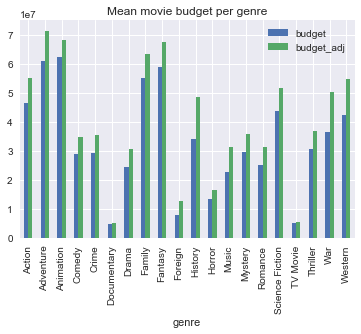

In [10]:
movie_data_split_genre.groupby('genre').mean().plot.bar(y=['budget', 'budget_adj'], title='Mean movie budget per genre');


The four genres that get the most money for movies are Adventure, Animation, Fantasy and Family (both for original and normed values). 
'TV Movie' is not exactly a genre, but for these is not much money spent. This seems reasonably as there is less revenue to expect than for a movie shown in cinema.
Documentary, Foreign and Horror are the genres where fewest money per film is spent.

I am also interested in cumulated budgets: In which genre do I find the biggest slice of the cake?

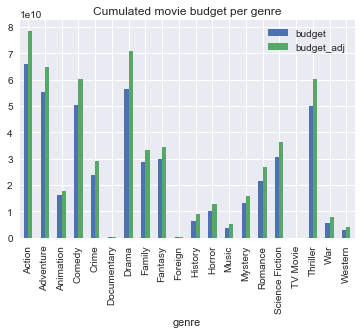

In [11]:
movie_data_split_genre.groupby('genre').sum().plot.bar(y=['budget', 'budget_adj'], title='Cumulated movie budget per genre');

Here we have a different  picture: The most cumulated money goes to Action, Drama, Adventure, Comedy and Thriller.
Drama, Comedy and Thriller win a lot in comparison to per-movie budget, Animation loses most.

Now let's have look how the budgets per movie differ over time.

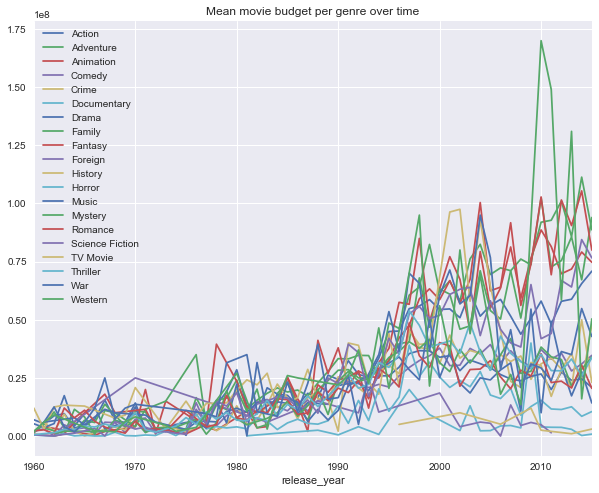

In [12]:
# Sources:
# http://queirozf.com/entries/pandas-dataframe-groupby-examples


movie_data_split_genre.groupby(['genre', 'release_year']).budget.mean().to_frame() \
    .reset_index(level='genre').groupby('genre')['budget'].plot(figsize=(10, 8), legend=True, title='Mean movie budget per genre over time');

This graph shows that movie budgets increase over time. As this may be due to correlation, it is better to plot the normed budget data:

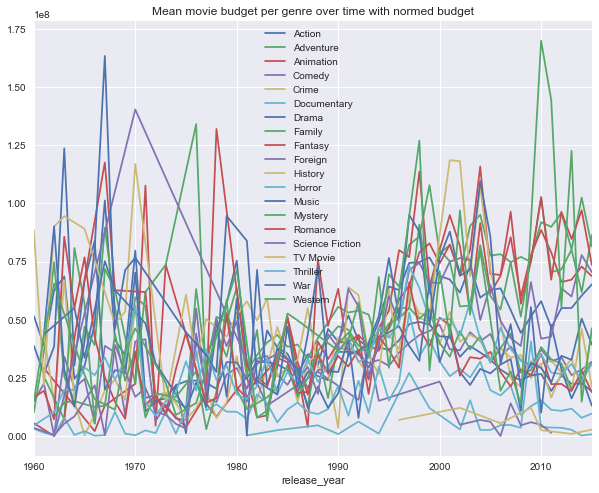

In [13]:
movie_data_split_genre.groupby(['genre', 'release_year']).budget_adj.mean().to_frame() \
    .reset_index(level='genre').groupby('genre')['budget_adj'].plot(figsize=(10, 8), legend=True, title='Mean movie budget per genre over time with normed budget');

It looks rather chaotic, but there is a decrease visible between 1980 and 1995.
Next is the cumulated budget per year (already with normed budgets):

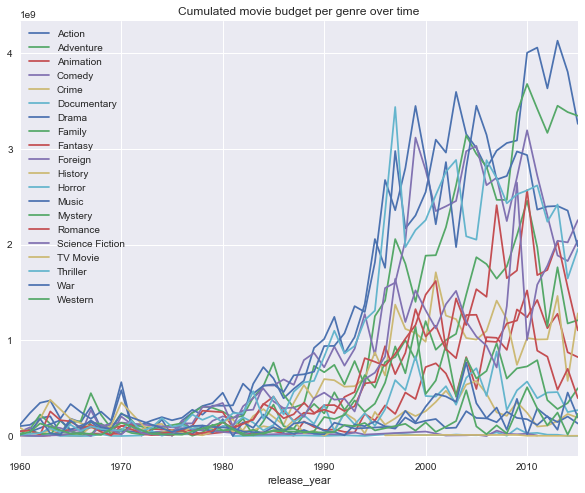

In [14]:
movie_data_split_genre.groupby(['genre', 'release_year']).budget_adj.sum().to_frame() \
    .reset_index(level='genre').groupby('genre')['budget_adj'].plot(figsize=(10, 8), legend=True, title='Cumulated movie budget per genre over time');

Here we see that the money spent on movies in general got a lot higher over the years.
This could be due to more interest in movies, or the database just doesn't include many of the old movies.

The values rise strongely around 1995, which is also roughly when the Internet started to become available to people. 

<a id='q2'></a>

### Research Question 2: Is there a correlation between money spent on films and their revenue, popularity or TMDb rating?

For this analysis, I will first plot the scatterplot for all 3 dependent variables separately to get an overview.
I will use budget_adj and revenue_adj to eliminate inflation.

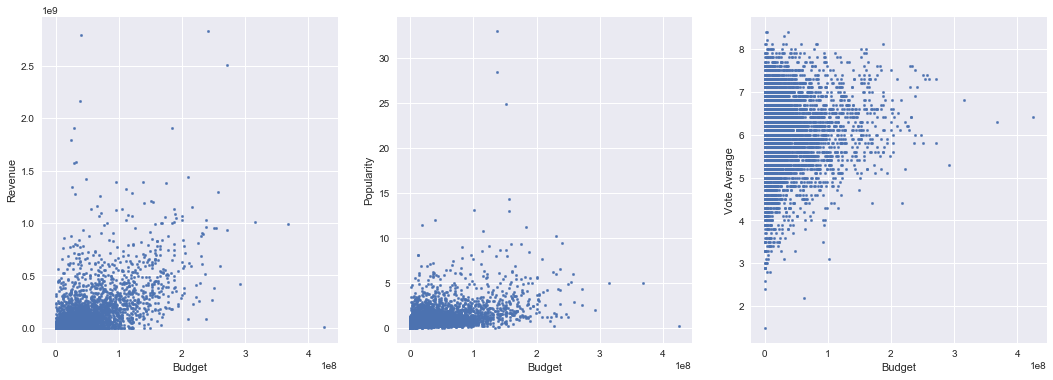

In [15]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.scatter('budget_adj', 'revenue_adj', data=movie_data, s=6)
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.subplot(132)
plt.scatter('budget_adj', 'popularity', data=movie_data, s=6)
plt.xlabel('Budget')
plt.ylabel('Popularity')
plt.subplot(133)
plt.scatter('budget_adj', 'vote_average', data=movie_data, s=6)
plt.xlabel('Budget')
plt.ylabel('Vote Average')
plt.show()


A correlation is not clearly visible. I will calculate Pearson's R to examine this further.

In [16]:
def correlation(x, y): # from Lesson
    standardized_x = (x - x.mean()) / x.std(ddof=0)
    standardized_y = (y - y.mean()) / y.std(ddof=0)
    
    correlation = (standardized_x * standardized_y).mean()
    return correlation

pearson_revenue = correlation(movie_data['budget_adj'], movie_data['revenue_adj'])
pearson_popularity = correlation(movie_data['budget_adj'], movie_data['popularity'])
pearson_voting = correlation(movie_data['budget_adj'], movie_data['vote_average'])

print('Pearson\'s R for correlation with budget spent: ', '\nRevenue:', pearson_revenue, \
      '\nPopularity:', pearson_popularity, '\nVote Average:', pearson_voting)

Pearson's R for correlation with budget spent:  
Revenue: 0.5923738672516269 
Popularity: 0.4353363637164347 
Vote Average: 0.11222599460413965


There is a medium positive correlation between budget and revenue als well as a moderate positive correlation between budget and popularity. There is no correlation for budget and vote average.

Now I am interested about the correlation between these three factors, let's have a look.


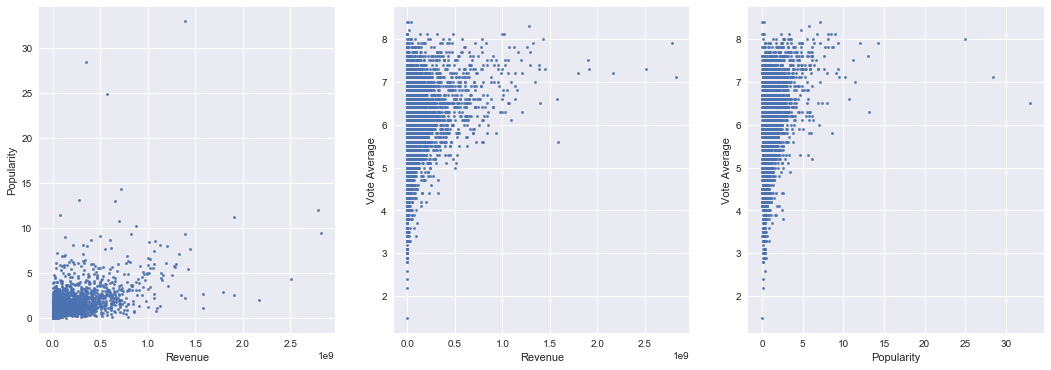

Pearson's R for correlation:  
Revenue and Popularity: 0.5773497448652842 
Revenue and Vote Average: 0.2774757567212353 
Popularity and Vote Average: 0.31284318376882353


In [17]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.scatter('revenue_adj','popularity', data=movie_data, s=6)
plt.xlabel('Revenue')
plt.ylabel('Popularity')
plt.subplot(132)
plt.scatter('revenue_adj', 'vote_average', data=movie_data, s=6)
plt.xlabel('Revenue')
plt.ylabel('Vote Average')
plt.subplot(133)
plt.scatter('popularity', 'vote_average', data=movie_data, s=6)
plt.xlabel('Popularity')
plt.ylabel('Vote Average')
plt.show()

pearson_rev_pop = correlation(movie_data['revenue_adj'], movie_data['popularity'])
pearson_rev_vote = correlation(movie_data['revenue_adj'], movie_data['vote_average'])
pearson_pop_vote = correlation(movie_data['popularity'], movie_data['vote_average'])

print('Pearson\'s R for correlation: ', '\nRevenue and Popularity:', pearson_rev_pop, \
      '\nRevenue and Vote Average:', pearson_rev_vote, '\nPopularity and Vote Average:', pearson_pop_vote)

There is a medium positive correlation between popularity and revenue. I would have thought it to be stronger as I thought the most popular movie would also collect the most money.

For Vote Average, there is no correlation to any of these variables. It seems to be random.

<a id='q3'></a>
### Research Question 3: Does the movie runtime correlate with money spent on it and is there a significant change for 1. with budget normed to runtime?

For this analysis, I need to clean the data from runtime values of 0 as I cannot analyse these.

In [18]:
movie_data_cleaned_runtime = movie_data.loc[movie_data.loc[:, 'runtime'] != 0].copy()

Next, I plot the runtime against the spent budget and calculate Pearson's R.

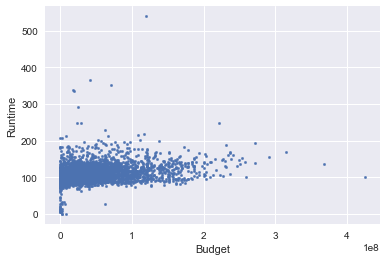

Pearson's R for correlation:  0.5923738672516269


In [19]:
plt.scatter('budget_adj','runtime', data=movie_data, s=6)
plt.xlabel('Budget')
plt.ylabel('Runtime')
plt.show()
pearson_runtime = correlation(movie_data['budget_adj'], movie_data['revenue_adj'])
print('Pearson\'s R for correlation: ', pearson_runtime)

The plot does not look like it, but the calculation proposes a medium positive correlation.

How does this differ for the genres? 

So now, I will produce a budget value normed by the runtime and reproduce the charts from Question 1.

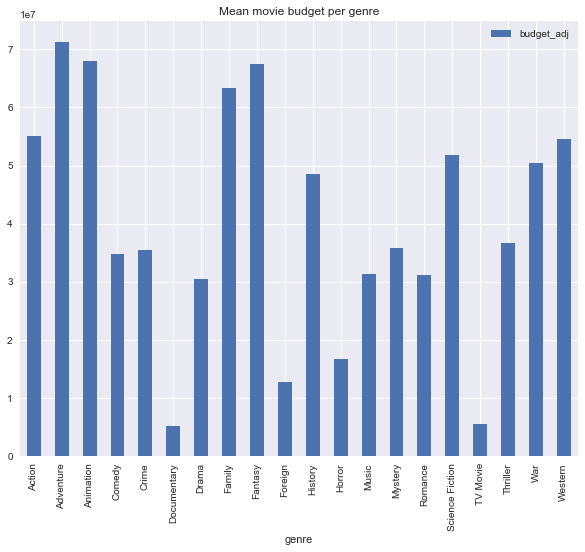

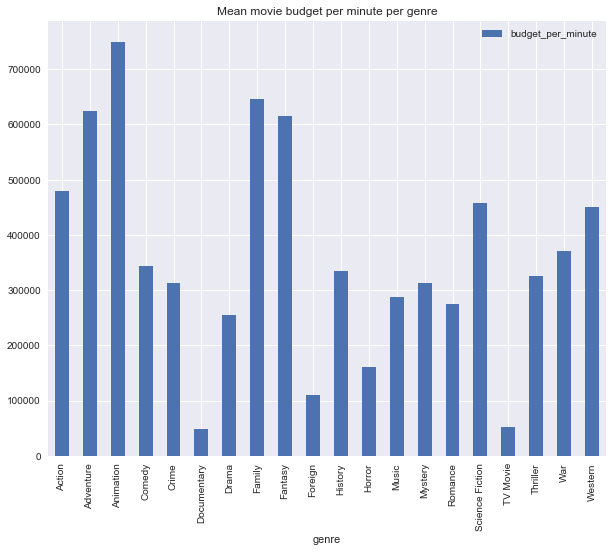

In [20]:
movie_data_cleaned_runtime['budget_per_minute'] = movie_data_cleaned_runtime['budget_adj'] / movie_data_cleaned_runtime['runtime']

keep_list_budget_per_min = ['id', 'popularity', 'budget', 'revenue', 'original_title', 'runtime', \
                                  'vote_count', 'vote_average', 'release_year', 'budget_adj', 'revenue_adj', 'budget_per_minute']
split_genre_budget_per_min = split_per_genre(movie_data_cleaned_runtime, keep_list_budget_per_min)


movie_data_split_genre.groupby('genre').mean().plot.bar(y=['budget_adj'], figsize=(10, 8), title='Mean movie budget per genre')
split_genre_budget_per_min.groupby('genre').mean().plot.bar(y=['budget_per_minute'], figsize=(10, 8), title='Mean movie budget per minute per genre');

The Animation genre is the most expensive genre per minute. The Family genre also is high here, I guess that this is because most Family movies are animated.

Now I print this distribution per release year:

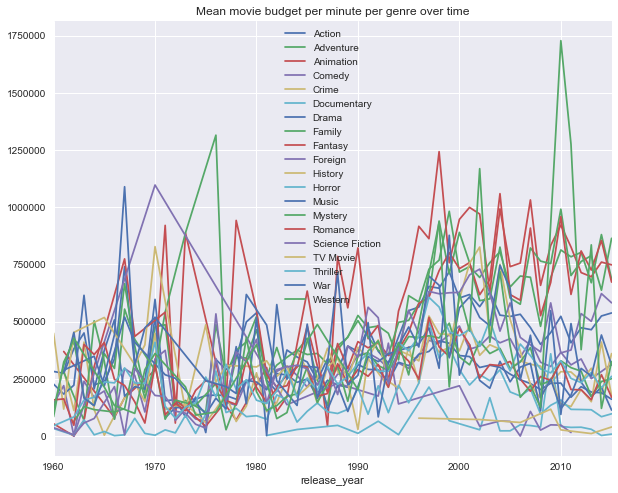

In [21]:
split_genre_budget_per_min.groupby(['genre', 'release_year']).budget_per_minute.mean().to_frame() \
    .reset_index(level='genre').groupby('genre')['budget_per_minute'].plot(figsize=(10, 8), legend=True, title='Mean movie budget per minute per genre over time');

<a id='conclusions'></a>
## Conclusions

This analysis shows that there is spent different movie budget in different genres over time, and if we assume that this database is representative, the cumulative money spent on movies growed over time.

It showed medium correlations between budget, revenue and popularity, but the vote average showed no correlations at all.

The budget is also correlated to the runtime of the movie. This results in a different picture for budget-per-minute per genre than for complete movie budget.